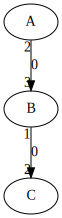

In [30]:
from sdf_expander import Sdf, Hsdf
sdf = Sdf()
sdf.add_actor('A')
sdf.add_actor('B')
sdf.add_actor('C')
sdf.add_channel('A', 2,'B', 3)
sdf.add_channel('B', 1, 'C', 2)
#sdf.add_channel('A', 1, 'A', 1, 1)
#sdf.add_channel('B', 1, 'B', 1, 1)
#sdf.add_channel('C', 1, 'C', 1, 1)
sdf

In [24]:
sdf.channels

(Channel(source=0, target=1, source_production_rate=2, target_consumption_rate=3, initial_tokens=0),
 Channel(source=1, target=2, source_production_rate=1, target_consumption_rate=2, initial_tokens=0))

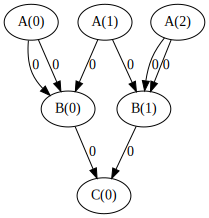

In [31]:
sdf.to_hsdf()

In [32]:
from pulp import *
import numpy as np
from typing import Dict 
def problem(hsdf: Hsdf, execution_time: Dict[str, int]) -> tuple[LpProblem, Dict[tuple[str,int], LpVariable], LpVariable]:
    
    prob = LpProblem("Problem", LpMaximize)
    
    throughput = LpVariable("t", lowBound=0)
    u = {(a, k): LpVariable(f"u({a}({k}))", lowBound=0) for (a, k) in hsdf.actors()}
    
    prob.setObjective(throughput)
    
    for i, (s, t, initial_tokens) in enumerate(hsdf.channels()):
        prob += u[t] >= u[s] + throughput*execution_time[s[0]] - initial_tokens, f"channel({u[s]},{u[t]},{i})"
        
    return (prob, u, throughput)
        

In [27]:
def ceil(x: LpAffineExpression, name: str, prob: LpProblem, pos_cost: bool):
    y = LpVariable(name, cat='Integer', lowBound=0)
    if pos_cost:
        prob += y >= x
    else:
        prob += y <= x + 0.9999
    return y

def memory_at_time(
    t: LpAffineExpression,
    hsdf: Hsdf,
    start_memory_cost: Dict[str, int],
    end_memory_cost: Dict[str, int],
    execution_time: Dict[str, int],
    prob: LpProblem,
    u: Dict[tuple[str,int], LpVariable],
    throughput: LpVariable,
    name: str) -> LpAffineExpression:
    
    return sum(start_memory_cost[a[0]] * ceil(t - u[a], f"memory({name},start({u[a].name}))", prob, True) for a in hsdf.actors()) + \
        sum(end_memory_cost[a[0]] * ceil(t - u[a] - throughput*execution_time[a[0]], f"memory({name},end({u[a].name}))", prob, False) for a in hsdf.actors())
    

In [35]:
max_memory = 7
hsdf = sdf.to_hsdf()
execution_time = {
    'A': 1,
    'B': 2,
    'C': 2
}
start_memory_cost = { a: sum(c.source_production_rate for c in sdf.channels if c.source == i) for i, a in enumerate(sdf.actors) }
end_memory_cost = { a: -sum(c.target_consumption_rate for c in sdf.channels if c.target == i) for i, a in enumerate(sdf.actors) }

prob, u, throughput = problem(hsdf, execution_time)
for a in hsdf.actors():
    prob += max_memory >= memory_at_time(
        u[a] + throughput*execution_time[a[0]],
        hsdf,
        start_memory_cost,
        end_memory_cost,
        execution_time,
        prob,
        u,
        throughput,
        f"end({u[a]})"), f"memory_at(end({u[a]}))"
prob.solve(GUROBI_CMD())

Set parameter Username
Set parameter LogFile to value "gurobi.log"
Academic license - for non-commercial use only - expires 2024-07-23
Using license file /home/andful/gurobi.lic

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)
Copyright (c) 2023, Gurobi Optimization, LLC

Read LP format model from file /tmp/b93b0d300e2348c49b8c23b857d9dffd-pulp.lp
Reading time = 0.00 seconds
OBJ: 86 rows, 79 columns, 318 nonzeros

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 86 rows, 79 columns and 318 nonzeros
Model fingerprint: 0x4bd1650f
Variable types: 7 continuous, 72 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 20 rows and 29 columns
Presolve time: 0.0

1

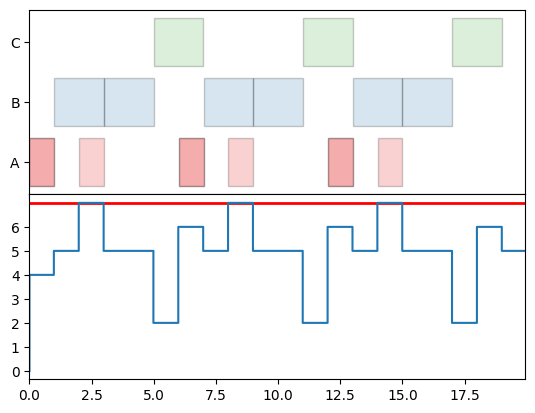

(0.0, 19.951260126012603)

In [36]:
def memory_usage(
    t: np.ndarray, 
    sdf: Sdf,
    execution_time: Dict[str, int],
    start_memory_cost: Dict[str, int],
    end_memory_cost: Dict[str, int],
    u: Dict[tuple[str,int], LpVariable],
    throughput: LpVariable,
    cyclic_memory: bool
                ):
    import numpy as np
    memory = np.zeros(len(t))
    cycle_time = 1/throughput.value()
    start_times = np.array([cycle_time * u[(a, k)].value() for (a, k) in sdf.to_hsdf().actors()])
    
    for (a, k) in sdf.to_hsdf().actors():
        start_time = round(cycle_time*u[(a, k)].value())
        production = np.ceil((t - start_time)/cycle_time)
        consumption = np.ceil((t - (start_time + execution_time[a[0]]))/cycle_time)
        if not cyclic_memory:
            production = np.maximum(production, 0)
            consumption = np.maximum(consumption, 0)
        memory += start_memory_cost[a[0]] * production
        memory += end_memory_cost[a[0]] * consumption
    return memory

def plot_solution(
    sdf: Sdf,
    execution_time: Dict[str, int],
    u: Dict[tuple[str,int], LpVariable],
    throughput: LpVariable,
    max_memory: int,
    cyclic_memory: bool = False
):
    import matplotlib.pyplot as plt
    from matplotlib import colormaps
    import numpy as np
    
    fig, [ax_time, ax_memory] = plt.subplots(2, sharex='col',gridspec_kw={'hspace': 0, 'wspace': 0})
    cm = colormaps['Set1']
    
    colors = cm(range(len(sdf.actors)))
    actor2index = {a: i for i, a in enumerate(sdf.actors)}
    cycle_time = 1/throughput.value()
    
    repetition = 3
    
    actors = list(sdf.to_hsdf().actors())
    indices = np.array([actor2index[a] for (a, l) in actors] * repetition)
    c = colors[indices]
    execution_times = np.array([execution_time[a] for (a, l) in actors] * repetition)
    start_times = np.array([cycle_time * u[(a, k)].value() + i*cycle_time for i in range(repetition) for (a, k) in actors])
    
    ax_time.barh(y=indices, width=execution_times, left=start_times, color=c, linewidth=1, ec="black", alpha=0.2)
    ax_time.set_yticks(range(len(sdf.actors)), sdf.actors)
    xlim = ax_time.get_xlim()
    x_memory1 = np.linspace(0, np.ceil(xlim[1]), 1000)
    x_memory2 = np.arange(np.ceil(xlim[1]))
    m1 = memory_usage(x_memory1, sdf, execution_time, start_memory_cost, end_memory_cost, u , throughput, cyclic_memory)
    m2 = memory_usage(x_memory2, sdf, execution_time, start_memory_cost, end_memory_cost, u , throughput, cyclic_memory)
    xmin, xmax = xlim
    ax_memory.hlines(y=max_memory, xmin=xmin, xmax=xmax, linewidth=2, color='r')
    ax_memory.step(x_memory1, m1)
    #ax_memory.step(x_memory2, m2)
    ax_memory.set_xlim(xlim)
    ax_memory.set_yticks(range(np.ceil(np.max(m1)).astype(int)))
    plt.show()
    return xlim
    
plot_solution(sdf, execution_time, u, throughput, max_memory, False)

In [17]:
hsdf = sdf.to_hsdf()
execution_time = {
    'A': 1,
    'B': 2,
    'C': 2
}
start_memory_cost = { a: sum(c.source_production_rate for c in sdf.channels if c.source == i) for i, a in enumerate(sdf.actors) }
end_memory_cost = { a: -sum(c.target_consumption_rate for c in sdf.channels if c.target == i) for i, a in enumerate(sdf.actors) }

ts = []
ms = []

throughput = None
memory = 50
while True:
    prob, u, throughput = problem(hsdf, execution_time)
    for a in hsdf.actors():
        prob += memory >= memory_at_time(u[a] + throughput*execution_time[a[0]], hsdf, start_memory_cost, end_memory_cost, execution_time, prob, u, throughput, f"end({u[a]})"), f"memory_at(end({u[a]}))"
    solution = prob.solve(GUROBI_CMD(msg=0))
    if solution == 0:
        break
    ms.append(memory)
    ts.append(throughput.value())
    print(f"{solution} {memory} {throughput.value()} {throughput.value() > 0.001}")
    memory -= 1
    



1 50 0.24997499999999997 True
1 49 0.24997499999999997 True
1 48 0.24997499999999997 True
1 47 0.24997499999999997 True
1 46 0.24997499999999997 True
1 45 0.24997499999999997 True
1 44 0.24997499999999997 True
1 43 0.24997499999999997 True
1 42 0.24997499999999997 True
1 41 0.24997499999999997 True
1 40 0.24997499999999997 True
1 39 0.24997499999999997 True
1 38 0.24997499999999997 True
1 37 0.24997499999999997 True
1 36 0.24997499999999997 True
1 35 0.24997499999999997 True
1 34 0.24997499999999997 True
1 33 0.24997499999999997 True
1 32 0.24997499999999997 True
1 31 0.24997499999999997 True
1 30 0.24997499999999997 True
1 29 0.24997499999999997 True
1 28 0.24997499999999997 True
1 27 0.24997499999999997 True
1 26 0.24997499999999997 True
1 25 0.24997499999999997 True
1 24 0.24997499999999997 True
1 23 0.24997499999999997 True
1 22 0.24997499999999997 True
1 21 0.24997499999999997 True
1 20 0.24997499999999997 True
1 19 0.24997499999999997 True
1 18 0.24997499999999997 True
1 17 0.249

Text(0.5, 0, 'memory')

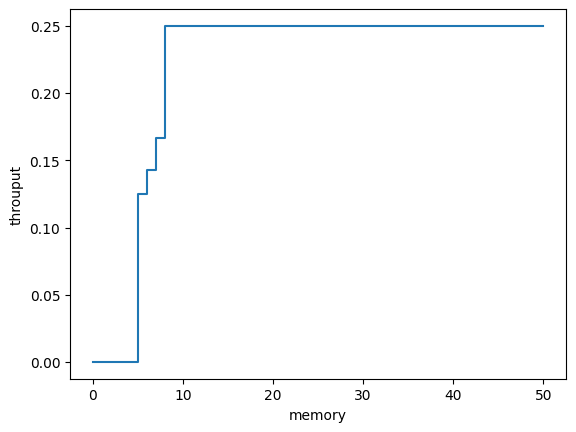

In [18]:
import matplotlib.pyplot as plt

plt.step(ms, ts)
plt.ylabel('throuput')
plt.xlabel('memory')

In [63]:
solution

1